## Imports

In [42]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm, neighbors, metrics, linear_model
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py
import seaborn as sns
from scipy.stats import levene, bartlett
from mpl_toolkits.mplot3d import axes3d
import math
from datetime import datetime
from tscv import GapKFold, GapWalkForward

## Data Wrangling
#### - Read dataset
#### - Transform and concat seperate datasets
#### - filter a subset dataframe from main dataframe

In [43]:
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
years = ['2018','2019']
dflist = []
for year in years:
    for month in months:
        if year == '2019' and month == 'December':
            pass
        else:
            main_df = pd.read_csv('datasets/cleaned_slippage_'+year+'/'+month+' '+year+'.csv',encoding='utf-8', engine='python')
            main_df = main_df[pd.notnull(main_df['Implementor'])]
            main_df = main_df[pd.notnull(main_df['Slippage'])]
            main_df['Contract Amount'] = main_df['Contract Amount'].replace(',','',regex=True).astype(float)
            main_df['Slippage'] = pd.Series([float(str(val).replace('%','')) for val in main_df['Slippage']], index=main_df.index)
            main_df['% WT Actual'] = pd.Series([float(str(val).replace('%','')) for val in main_df['% WT Actual']], index=main_df.index)
            main_df['% WT Plan'] = pd.Series([float(str(val).replace('%','')) for val in main_df['% WT Plan']], index=main_df.index)
            main_df['Report Date'] = datetime.strptime(month+' '+year, '%B %Y')
            main_df['Month'] = month
            main_df['Year'] = year
            main_df['index'] = main_df['Report Date']
            #replace null values with outlying value
            del main_df['Unnamed: 0']
            main_df = main_df.loc[main_df['Implementor']=='FREDEN CONSTRUCTION']
            dflist.append(main_df)
    
df = pd.concat(dflist)
df.set_index('index', inplace=True)
df.index = pd.to_datetime(df.index)

## Resampling
#### - Upsampling of each project's timeline from monthly to daily.
#### - Interpolation of continuous data.
##### [Polynomial, Spline, Gaussian Process Regression (*kriging*)]

In [44]:
proj_list = [proj for proj in df['Name of Project'].values]
project_list = []
for project in set(proj_list):
    rec_df = df.loc[df['Name of Project']==project]
    order = (rec_df.shape[0]) - 1
    if order >= 5: order = 5
    itpd_df = rec_df.resample("D").interpolate(method='spline', order=order)
    itpd_df = itpd_df.fillna(method='pad')
    project_list.append(itpd_df)
    
fuck = pd.concat(project_list)

### Exploratory Data Analysis

In [16]:
# proj_count=[]
# x = []
# for year in years:
#     for month in months:
# #mylist=df.loc[(df['ratings'] < 3) & (df['business_id'] == id),'review_text'].values.tolist()

#         #print(df['Name of Project'].loc[(df['Month']==month) & (df['Year']==year)].values)
#         proj_count.append(len(df['Name of Project'].loc[(df['Month']==month) & (df['Year']==year)].values.tolist()))
#         x.append(month + year)
# plt.bar(x,proj_count,width=0.5)
# plt.subplots_adjust(left=0, bottom=0, right=3, top=1.5,wspace=0, hspace=0)
# plt.xticks(rotation=45, ha="right")
# plt.grid(True)

# for project in set(proj_list):
#     rec_df = fuck.loc[fuck['Name of Project']==project]
# #     plt.plot(rec_df['Slippage'])
#     plt.plot(rec_df['% WT Plan'], label='Plan')
#     plt.plot(rec_df['% WT Actual'], label='Actual')
#     plt.subplots_adjust(left=0, bottom=0, right=2, top=1.5,wspace=0, hspace=0)
#     plt.title(project)
#     plt.legend()
#     plt.grid(True)
#     plt.show()


### Define selected features and other parameters to be used in cross validation

In [89]:
X = fuck[['% WT Plan','No. of Days','Contract Amount']]
y = fuck['Slippage']

weights = 'distance'
k=9 # number of neighbours 
max_iter = 500 # number of iterations the model is being run
min_perc = 82 # lowest allowable adjusted r^2 score for model
linear_model = neighbors.KNeighborsRegressor(k,weights=weights)

## Validation of Bias-Variance tradeoff in using KNN Regressor, and finding the optimum ***k*** value

In [18]:
# k_range = range(1,100)

# train_rmse_list = []
# rmse_list = []

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# for k in k_range:

#     linear_model = neighbors.KNeighborsRegressor(k,weights=weights)
#     model = linear_model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     mse = 1/len(y_pred)*sum((y_test-y_pred)**2)
#     rmse = np.sqrt(mse)
# #     ssr = sum((y_test - y_pred)**2)
# #     sst = sum((y_test - np.mean(y_test))**2)
# #     r2 = 1 - (ssr/sst)
# #     adj_r2 = 1-(1-r2)*(len(y_test)-1)/(len(y_test)-(X_test.shape[1])-1)

#     train_rmse_list.append(train_rmse_list)
#     rmse_list.append(rmse)

    
# plt.plot(k_range, train_rmse_list)
# plt.plot(k_range, rmse_list)
# plt.ylabel('RMSE')
# plt.xlabel('k')
# plt.grid(True)
# plt.show()
    
# # for project in set(proj_list):
# #     rec_df = fuck.loc[fuck['Name of Project']==project]
# #     slips = rec_df['Slippage'].values
# #     sns.distplot(slips)
# #     plt.show()
    

### Function for 3D plotting
***plot_3d(X[0], X[1], X[2], y, y_pred)***

In [46]:
def plot_3d(x1,x2,x3,y_test,y_pred):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')

    ax1.scatter(x1.values, x2.values, y_test, c='darkorange', alpha=0.5, label='data '+str(len(y_test)))
    ax1.scatter(x1.values, x2.values, y_pred, c='blue', alpha=0.5,label='predicted data '+str(len(y_pred)))
#     ax1.plot_trisurf(x1.values, x2.values, y_pred, color='red', alpha=0.1, linewidth=0, antialiased=False)

    ax1.set_xlabel('% WT Plan')
    ax1.set_ylabel('No. of Days')
    ax1.set_zlabel('Slippage')
    plt.subplots_adjust(left=0, bottom=0, right=2, top=1.5,wspace=0, hspace=0)
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')

    ax1.scatter(x2.values, x3.values, y_test, c='darkorange', alpha=0.5, label='data '+str(len(y_test)))
    ax1.scatter(x2.values, x3.values, y_pred, c='blue', alpha=0.5,label='predicted data '+str(len(y_pred)))
#     ax1.plot_trisurf(x2.values, x3.values, y_pred, color='red', alpha=0.1, linewidth=0, antialiased=False)

    ax1.set_xlabel('No. of Days')
    ax1.set_ylabel('Contract Amount')
    ax1.set_zlabel('Slippage')
    plt.subplots_adjust(left=0, bottom=0, right=2, top=1.5,wspace=0, hspace=0)
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')

    ax1.scatter(x1.values, x3.values, y_test, c='darkorange', alpha=0.5, label='data '+str(len(y_test)))
    ax1.scatter(x1.values, x3.values, y_pred, c='blue', alpha=0.5,label='predicted data '+str(len(y_pred)))
#     ax1.plot_trisurf(x1.values, x3.values, y_pred, color='red', alpha=0.1, linewidth=0, antialiased=False)

    ax1.set_xlabel('% WT Plan')
    ax1.set_ylabel('Contract Amount')
    ax1.set_zlabel('Slippage')
    plt.subplots_adjust(left=0, bottom=0, right=2, top=1.5,wspace=0, hspace=0)
    plt.show()

### Function for scoring
***score_model(X, y_test, y_pred)***    
returns: [adjusted R^2, Root Mean^2 Error]

In [82]:
def score_model(X, y_test, y_pred): 
    mse = 1/len(y_pred)*sum((y_test-y_pred)**2)
    rmse = np.sqrt(mse)
    ssr = sum((y_test - y_pred)**2)
    sst = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (ssr/sst)
    adj_r2 = 1-(1-r2)*(len(y_test)-1)/(len(y_test)-(len(X.columns))-1)
    
    return [adj_r2,rmse]

### Function for training model
##### ***score_model(X,y,test_set=True)*** 
set ***test_set*** to **False** when spiltting for validation set       
returns: [X_train, X_test, y_train, y_test, y_pred]

In [105]:
def train_model(X, y, test_set):
    for r in range(max_iter):   
        #Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

        #Preprocessing
        scaler = preprocessing.MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        #Fitting
        model = linear_model.fit(X_train,y_train)
        #Predicting
        y_pred = model.predict(X_test)
        if score_model(X, y_test, y_pred)[0] >= min_perc/100:
            print(score_model(X, y_test, y_pred)[0])
            if not test_set:
                X_train = np.concatenate((X_train, X_test), axis=0)
                y_train = np.concatenate((y_train, y_test), axis=0)
            return [X_train,X_test,y_train,y_test,y_pred]
        else: continue

### Using a more common approach *train_test_split* function to validate model's performance.

0.8244060867390048


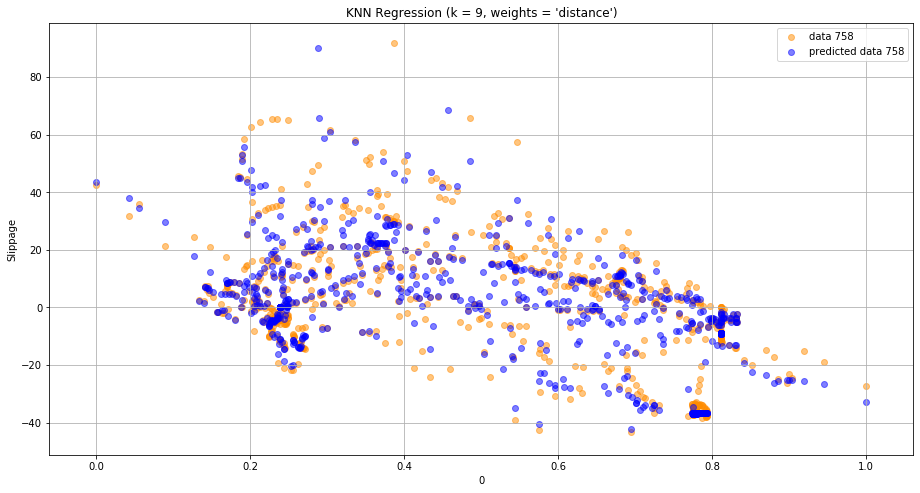

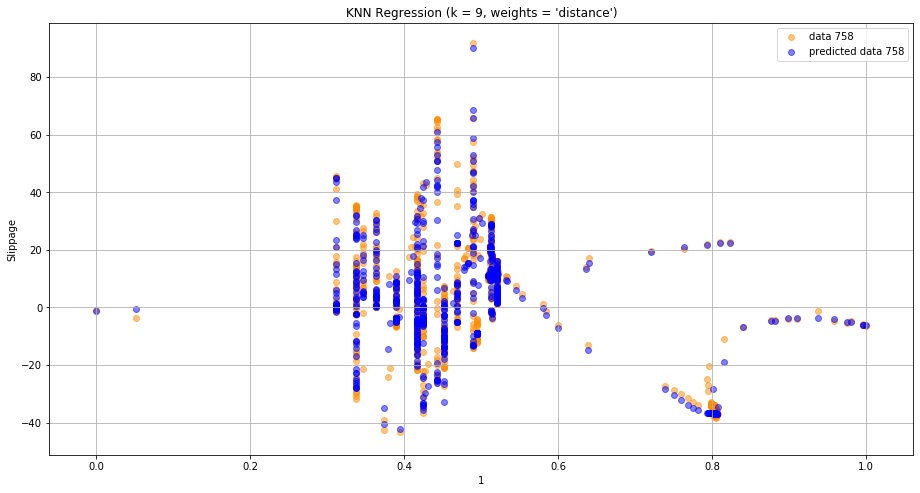

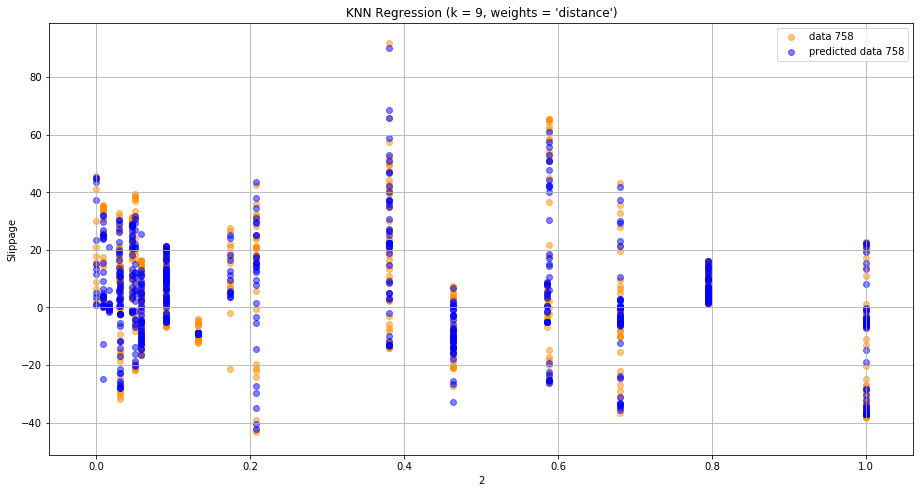

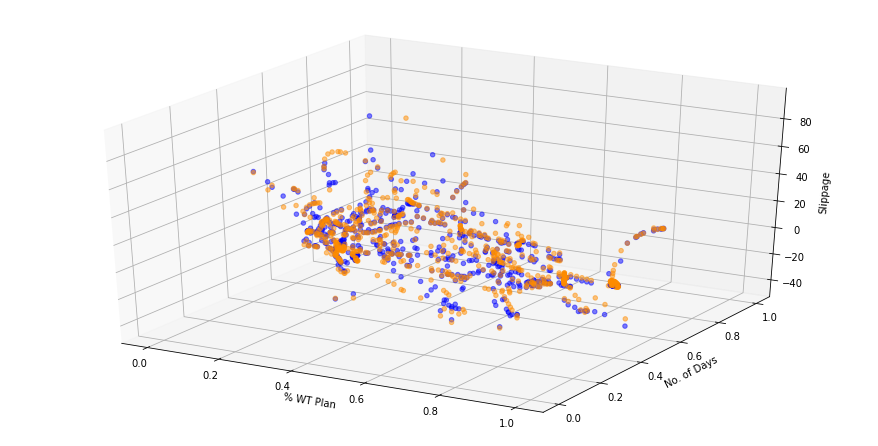

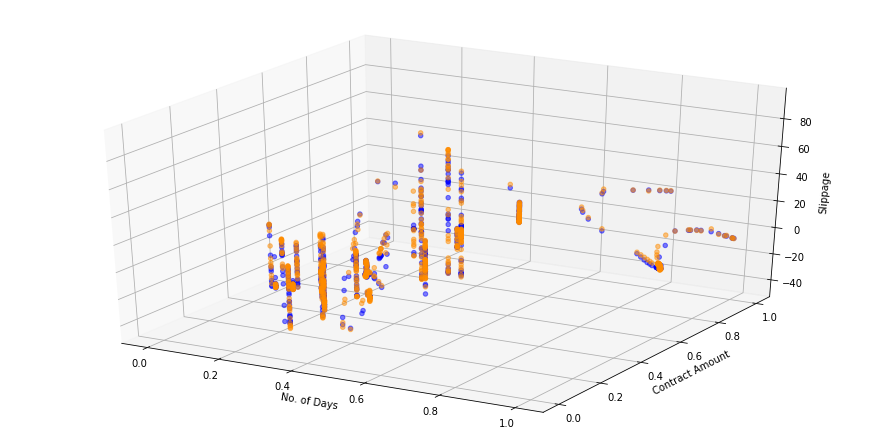

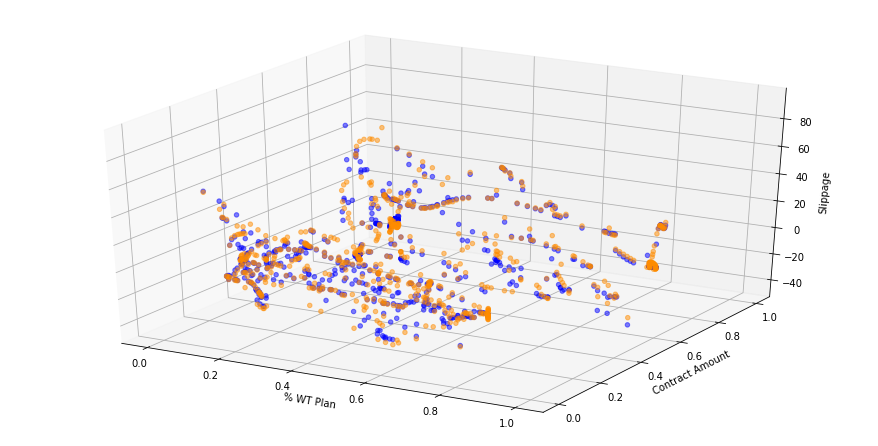

Adj. R squared of model is  0.8244060867390048
RMSE of model is  8.818446334956667


In [108]:
full_set = train_model(X,y,test_set=True)
X_train = full_set[0]
X_test = full_set[1]
y_train = full_set[2]
y_test = full_set[3]
y_pred = full_set[4]

#Visualisation
data = {'% WT Plan': X_test[:, 0], 'No. of Days': X_test[:, 1], 'Contract Amount': X_test[:, 2]}
X_test = pd.DataFrame(X_test)
if score_model(X, y_test, y_pred)[0] >= min_perc/100:
    for i, e in enumerate(X_test.columns):

        plt.scatter(X_test[e].values, y_test, color='darkorange',alpha=0.5, label='data '+str(len(y_test)))
        plt.scatter(X_test[e].values, y_pred, color='blue',alpha=0.5, label='predicted data '+str(len(y_pred)))
        plt.legend()
        plt.title("KNN Regression (k = %i, weights = '%s')" % (k,weights))
        plt.xlabel(e)
        plt.ylabel('Slippage')
        plt.subplots_adjust(left=0, bottom=0, right=2, top=1.5,wspace=0, hspace=0)
        plt.grid(True)
        plt.show()

    plot_3d(X_test[0],X_test[1],X_test[2],y_test,y_pred)

    print('Adj. R squared of model is ', score_model(X, y_test, y_pred)[0])
    print('RMSE of model is ', score_model(X, y_test, y_pred)[1])
            

### Comparison of the actual and predicted slippage's distribution

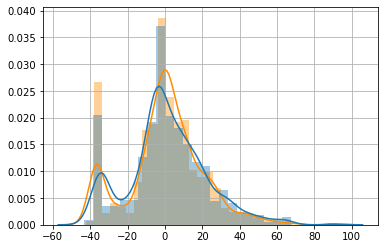

In [109]:
data = {'Slippage':[i for i in y_test],'y_pred':[i for i in y_pred]}
y_pred_df = pd.DataFrame(data=data)

preds = y_pred_df['y_pred'].values
sns.distplot(preds, color='darkorange')

slips = y_pred_df['Slippage'].values
sns.distplot(slips)

plt.grid(True)

#### ***Conclusion:*** *KNN Regression works well for noisy data (Since it is a non-parametric model and does not rely for distribution to be gaussian). However, with time series such as what we're using, it is inappropriate to implement traditional cross validation methods since data are all dependent chronogically to each other.*

## Modified Time Series Cross Validation
![alt text|124x124,25%](img/tscv_nested.png "Title")

### Time Series Cross Validation with gap

In [112]:
#Cross Validation
# tscv = GapWalkForward(n_splits=3, gap_size=1, test_size=round(len(X)*0.2))
tscv = GapWalkForward(n_splits=10, gap_size=5)
# tscv = GapKFold(n_splits=10, gap_before=1, gap_after=1)
# tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    full_train_set = train_model(X_train, y_train, test_set=False)
    if full_train_set:
        val_X_train = pd.DataFrame(full_train_set[0])
        val_y_train = pd.DataFrame(full_train_set[2])
        model = linear_model.fit(val_X_train, val_y_train)
        y_pred = model.predict(X_test)
        print(y_test)
        print(score_model(val_X_train, y_test, y_pred)[0])
#         if score_model(val_X_train, y_test, y_pred)[0] >= min_perc/100:

#             #VISUALISATION
#             print('R squared', r2_score(y_test,y_pred))
#             print('Adj. R squared of model is ', score_model(val_X_train, y_test, y_pred)[0])
#             print('RMSE of model is ', score_model(val_X_train, y_test, y_pred)[1])
      

           


0.859722144007881
index
2018-07-12   -6.998149
2018-07-13   -6.452924
2018-07-14   -5.910440
2018-07-15   -5.372186
2018-07-16   -4.839591
                ...   
2018-05-14   -3.938359
2018-05-15   -3.984234
2018-05-16   -3.976562
2018-05-17   -3.918230
2018-05-18   -3.812053
Name: Slippage, Length: 344, dtype: float64


Exception: Data must be 1-dimensional